In [1]:
import cv2
import os
import numpy as np

# Phân đoạn ảnh

In [2]:
def contourExtraction(image, k=10):
    """Lấy đường viền kí tự số"""

    # Chuyển ảnh sang không gian màu HSV
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Định nghĩa khoảng màu xanh dương trong không gian HSV
    lower_blue = np.array([100, 25, 25])
    upper_blue = np.array([140, 255, 255])

    # Tạo mặt nạ cho màu xanh dương
    blue_mask = cv2.inRange(hsv_image, lower_blue, upper_blue)

    # Tìm các contours của từng vùng màu xanh dương
    contours, _ = cv2.findContours(blue_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Lọc các contour có kích thước nhỏ
    min_width = 10
    min_height = 25
    max_height = 150
    filtered_contours = [c for c in contours if cv2.boundingRect(c)[2] > min_width and min_height < cv2.boundingRect(c)[3] < max_height]

    # Sắp xếp các contour theo diện tích (lấy các vùng lớn nhất)
    sorted_contours = sorted(filtered_contours, key=lambda c: cv2.contourArea(c), reverse=True)

    # Giới hạn chỉ lấy k contour lớn nhất
    number_contours = sorted_contours[:k]

    # Sắp xếp các contour theo trục x từ trái sang phải (vì đây là dãy số)
    number_contours = sorted(number_contours, key=lambda ctr: cv2.boundingRect(ctr)[0])

    return number_contours

In [3]:
def crop_img(dataset_dir):
    """Tìm các kí tự số trong ảnh và cắt để tạo dữ liệu huấn luyện"""
    # Thư mục để lưu các ảnh đã cắt
    cropped_folder = f"cropped_{dataset_dir}"
    if not os.path.exists(cropped_folder):
        os.makedirs(cropped_folder)

    for filename in os.listdir(dataset_dir):
        if filename.endswith('.jpg'):
        # Đường dẫn tới ảnh
            image_path = f"{dataset_dir}/{filename}"
            image = cv2.imread(image_path)
            image_name = os.path.splitext(os.path.basename(image_path))[0]

            number_contours = contourExtraction(image)

            # Đảm bảo rằng số contours và số ký tự trong image_name là như nhau
            if len(number_contours) != len(image_name):
                # print(f"Warning: File {filename} has {len(number_contours)} contours but {len(image_name)} digits.")
                # for i, contour in enumerate(number_contours):
                #     # Tạo bounding box cho từng vùng contour
                #     x, y, w, h = cv2.boundingRect(contour)

                #     # Cắt vùng ảnh tương ứng
                #     cropped_image = image[y:y+h, x:x+w]

                #     # Tạo tên file cho ảnh đã cắt
                #     cropped_image_name = f"errol_{i}_{image_name}.jpg"

                #     # Đường dẫn đầy đủ để lưu ảnh
                #     save_path = os.path.join(cropped_folder, cropped_image_name)

                #     # Lưu ảnh đã cắt
                #     cv2.imwrite(save_path, cropped_image)
                #     print(f"Đã lưu ảnh đã cắt tại: {save_path}")
                continue
            # Lặp qua từng contour và cắt từng vùng ảnh
            for i, contour in enumerate(number_contours):
                # Tạo bounding box cho từng vùng contour
                x, y, w, h = cv2.boundingRect(contour)

                # Cắt vùng ảnh tương ứng
                cropped_image = image[y:y+h, x:x+w]

                # Tạo tên file cho ảnh đã cắt
                cropped_image_name = f"{image_name[i]}_{i}_{image_name}.jpg"

                # Đường dẫn đầy đủ để lưu ảnh
                save_path = os.path.join(cropped_folder, cropped_image_name)

                # Lưu ảnh đã cắt
                cv2.imwrite(save_path, cropped_image)
                # print(f"Đã lưu ảnh đã cắt tại: {save_path}")
    return cropped_folder

In [4]:
crop_img(dataset_dir='train')
crop_img(dataset_dir='test')

'cropped_test'

# Rút trích đặc trưng

## Đặc trưng HOG

In [5]:
from skimage.feature import hog
def extract_hog(image):
    hog_features = hog(image,
                        orientations = 9,
                        pixels_per_cell=(8, 8),
                        cells_per_block=(4, 4),
                        visualize=False,
                        block_norm='L2-Hys')
    return hog_features

## Đặc trưng cạnh Sobel

In [6]:
def extract_sobel_edges(image):
    """Trích xuất đặc trưng cạnh Sobel từ ảnh"""
    # Tính toán Sobel theo hướng x và y
    sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)

    # Tính độ lớn gradient
    magnitude = np.sqrt(sobel_x**2 + sobel_y**2)

    # Chuẩn hóa giá trị về 0-1
    normalized_magnitude = cv2.normalize(magnitude, None, 0, 1, cv2.NORM_MINMAX)

    # Làm phẳng thành vector 1D
    return normalized_magnitude.flatten()


# Huấn luyện mô hình

## Tạo tập train và tập test

In [7]:
# Lấy tập train
dataset_dir = 'cropped_train'

# Danh sách chứa đặc trưng và nhãn
X_train_hog = []
y_train_hog = []

X_train_sobel = []
y_train_sobel = []

# Đọc từng ảnh trong dataset
for filename in os.listdir(dataset_dir):
    if filename.endswith('.jpg'):
        # Đọc ảnh
        img_path = os.path.join(dataset_dir, filename)
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        # Resize để chuẩn hóa kích thước
        resized_digit = cv2.resize(image, (64, 128))

        # Tính HOG
        hog_features = extract_hog(resized_digit)
        # Tính sobel
        sobel_features = extract_sobel_edges(resized_digit)

        # Lưu đặc trưng và nhãn
        X_train_hog.append(hog_features)
        X_train_sobel.append(sobel_features)

        # Lấy nhãn từ tên file (bỏ đuôi và chỉ lấy ký tự tương ứng)
        label = filename.split('_')[0]
        y_train_hog.append(label)
        y_train_sobel.append(label)

# Chuyển đổi thành numpy array
X_train_hog = np.array(X_train_hog)
y_train_hog = np.array(y_train_hog)

X_train_sobel = np.array(X_train_sobel)
y_train_sobel = np.array(y_train_sobel)

In [8]:
#Lấy tập test
dataset_test_dir = 'cropped_test'

# Danh sách chứa đặc trưng và nhãn
X_test_hog = []
y_test_hog = []

X_test_sobel = []
y_test_sobel = []

# Đọc từng ảnh trong dataset
for filename in os.listdir(dataset_test_dir):
    if filename.endswith('.jpg'):
        # Đọc ảnh
        img_path = os.path.join(dataset_test_dir, filename)
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        # Resize để chuẩn hóa kích thước
        resized_digit = cv2.resize(image, (64, 128))

        # Tính HOG
        hog_features = extract_hog(resized_digit)
        # Tính sobel
        sobel_features = extract_sobel_edges(resized_digit)

        # Lưu đặc trưng và nhãn
        X_test_hog.append(hog_features)
        X_test_sobel.append(sobel_features)

        # Lấy nhãn từ tên file (bỏ đuôi và chỉ lấy ký tự tương ứng)
        label = filename.split('_')[0]
        y_test_hog.append(label)
        y_test_sobel.append(label)

# Chuyển đổi thành numpy array
X_test_hog = np.array(X_test_hog)
y_test_hog = np.array(y_test_hog)

X_test_sobel = np.array(X_test_sobel)
y_test_sobel = np.array(y_test_sobel)

## Huấn luyện bằng SVM

In [9]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

param_grid_svm = {
    'C': [0.01, 0.1, 1, 10, 100],
    'kernel': ['rbf', 'linear']
}

# Tạo mô hình SVM
svm = SVC()

# Dùng GridSearchCV để tìm tham số tốt nhất cho hog features
grid_search_svm_hog = GridSearchCV(estimator=svm, param_grid=param_grid_svm, cv=5, scoring='accuracy')
grid_search_svm_hog.fit(X_train_hog, y_train_hog)

best_params_svm_hog = grid_search_svm_hog.best_params_
best_score_svm_hog = grid_search_svm_hog.best_score_

print("HOG Features")
print(f"Tham số tốt nhất: {best_params_svm_hog}")
print(f"Độ chính xác tốt nhất: {best_score_svm_hog}")

# Sobel features
grid_search_svm_sobel = GridSearchCV(estimator=svm, param_grid=param_grid_svm, cv=5, scoring='accuracy')
grid_search_svm_sobel.fit(X_train_sobel, y_train_sobel)

best_params_svm_sobel = grid_search_svm_sobel.best_params_
best_score_svm_sobel = grid_search_svm_sobel.best_score_

print("Sobel Features")
print(f"Tham số tốt nhất: {best_params_svm_sobel}")
print(f"Độ chính xác tốt nhất: {best_score_svm_sobel}")

HOG Features
Tham số tốt nhất: {'C': 0.1, 'kernel': 'linear'}
Độ chính xác tốt nhất: 0.9862500000000001
Sobel Features
Tham số tốt nhất: {'C': 10, 'kernel': 'rbf'}
Độ chính xác tốt nhất: 0.9574999999999999


In [10]:
from sklearn.metrics import accuracy_score, classification_report
# HOG features
model_svm_hog = SVC(**best_params_svm_hog)
model_svm_hog.fit(X_train_hog, y_train_hog)

y_pred_svm_hog = model_svm_hog.predict(X_test_hog)

print("SVM", "HOG Features" ,f"{best_params_svm_hog}")
print('Accuracy:', accuracy_score(y_test_hog, y_pred_svm_hog))
print(classification_report(y_test_hog, y_pred_svm_hog))

SVM HOG Features {'C': 0.1, 'kernel': 'linear'}
Accuracy: 0.96
              precision    recall  f1-score   support

           0       1.00      0.97      0.99        34
           1       0.95      0.95      0.95        22
           2       0.84      1.00      0.91        16
           3       0.96      0.92      0.94        26
           4       0.93      1.00      0.97        14
           5       1.00      0.93      0.97        15
           6       1.00      0.92      0.96        12
           7       1.00      1.00      1.00        27
           8       1.00      1.00      1.00        12
           9       0.91      0.91      0.91        22

    accuracy                           0.96       200
   macro avg       0.96      0.96      0.96       200
weighted avg       0.96      0.96      0.96       200



In [11]:
# Sobel features
model_svm_sobel = SVC(**best_params_svm_sobel)
model_svm_sobel.fit(X_train_sobel, y_train_sobel)

y_pred_svm_sobel = model_svm_sobel.predict(X_test_sobel)
print('SVM', 'Sobel Features', f'{best_params_svm_sobel}')
print('Accuracy:', accuracy_score(y_test_sobel, y_pred_svm_sobel))
print(classification_report(y_test_sobel, y_pred_svm_sobel))

SVM Sobel Features {'C': 10, 'kernel': 'rbf'}
Accuracy: 0.9
              precision    recall  f1-score   support

           0       1.00      0.94      0.97        34
           1       0.94      0.73      0.82        22
           2       0.93      0.88      0.90        16
           3       0.88      0.85      0.86        26
           4       0.74      1.00      0.85        14
           5       1.00      0.87      0.93        15
           6       1.00      0.92      0.96        12
           7       0.87      1.00      0.93        27
           8       0.71      1.00      0.83        12
           9       0.95      0.86      0.90        22

    accuracy                           0.90       200
   macro avg       0.90      0.90      0.90       200
weighted avg       0.91      0.90      0.90       200



## Huấn luyện bằng KNN

In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

param_grid_knn = {
  'n_neighbors': list(range(1, 21)),
  'metric': ['euclidean', 'manhattan', 'minkowski']
}

# Tạo mô hình KNN
knn = KNeighborsClassifier()

grid_search_knn = GridSearchCV(estimator=knn,
                               param_grid=param_grid_knn,
                               cv=5,
                               scoring='accuracy')

# Dùng GridSearchCV để tìm tham số k tốt nhất
grid_search_knn_hog = GridSearchCV(estimator=knn, param_grid=param_grid_knn, cv=5, scoring='accuracy')
grid_search_knn_hog.fit(X_train_hog, y_train_hog)

best_params_knn_hog = grid_search_knn_hog.best_params_
best_score_knn_hog = grid_search_knn_hog.best_score_

print("HOG Features")
print(f"Tham số tốt nhất: {best_params_knn_hog}")
print(f"Độ chính xác tốt nhất: {best_score_knn_hog}")

# Sobel features
grid_search_knn_sobel = GridSearchCV(estimator=knn, param_grid=param_grid_knn, cv=5, scoring='accuracy')
grid_search_knn_sobel.fit(X_train_sobel, y_train_sobel)

best_params_knn_sobel = grid_search_knn_sobel.best_params_
best_score_knn_sobel = grid_search_knn_sobel.best_score_

print("Sobel Features")
print(f"Tham số tốt nhất: {best_params_knn_sobel}")
print(f"Độ chính xác tốt nhất: {best_score_knn_sobel}")

HOG Features
Tham số tốt nhất: {'metric': 'manhattan', 'n_neighbors': 1}
Độ chính xác tốt nhất: 0.9799999999999999
Sobel Features
Tham số tốt nhất: {'metric': 'manhattan', 'n_neighbors': 1}
Độ chính xác tốt nhất: 0.93125


In [13]:
model_knn_hog = KNeighborsClassifier(**best_params_knn_hog)
model_knn_hog.fit(X_train_hog, y_train_hog)

y_pred_knn_hog = model_knn_hog.predict(X_test_hog)

print('KNN','HOG Features', f'{best_params_knn_hog}')
print('Accuracy:', accuracy_score(y_test_hog, y_pred_knn_hog))
print(classification_report(y_test_hog, y_pred_knn_hog))

KNN HOG Features {'metric': 'manhattan', 'n_neighbors': 1}
Accuracy: 0.94
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        34
           1       0.95      0.95      0.95        22
           2       0.94      1.00      0.97        16
           3       0.92      0.92      0.92        26
           4       0.74      1.00      0.85        14
           5       0.92      0.80      0.86        15
           6       1.00      0.92      0.96        12
           7       1.00      0.96      0.98        27
           8       1.00      1.00      1.00        12
           9       0.90      0.82      0.86        22

    accuracy                           0.94       200
   macro avg       0.94      0.94      0.93       200
weighted avg       0.95      0.94      0.94       200



In [14]:
model_knn_sobel = KNeighborsClassifier(**best_params_knn_sobel)
model_knn_sobel.fit(X_train_sobel, y_train_sobel)

y_pred_knn_sobel = model_knn_sobel.predict(X_test_sobel)

print('KNN','Sobel Features', f'{best_params_knn_sobel}')
print('Accuracy:', accuracy_score(y_test_sobel, y_pred_knn_sobel))
print(classification_report(y_test_sobel, y_pred_knn_sobel))

KNN Sobel Features {'metric': 'manhattan', 'n_neighbors': 1}
Accuracy: 0.87
              precision    recall  f1-score   support

           0       1.00      0.94      0.97        34
           1       0.80      0.73      0.76        22
           2       1.00      0.88      0.93        16
           3       0.80      0.92      0.86        26
           4       0.57      0.93      0.70        14
           5       0.80      0.80      0.80        15
           6       1.00      0.92      0.96        12
           7       0.90      0.96      0.93        27
           8       1.00      0.83      0.91        12
           9       1.00      0.73      0.84        22

    accuracy                           0.87       200
   macro avg       0.89      0.86      0.87       200
weighted avg       0.89      0.87      0.87       200



# Dự đoán ảnh

In [15]:
def predict_phone_number(image_path, extract_feature, model, k=10):
    """Dự đoán số trong ảnh"""
    # Đọc ảnh
    image = cv2.imread(image_path)

    number_contours = contourExtraction(image, k)

    phone_sender = ""
    phone_receiver = ""

    # Duyệt qua từng contour để cắt và nhận diện ký tự
    for cnt in number_contours:
        x, y, w, h = cv2.boundingRect(cnt)
        single_digit = cv2.cvtColor(image[y:y+h, x:x+w], cv2.COLOR_BGR2GRAY)


        # Resize để chuẩn hóa kích thước
        resized_digit = cv2.resize(single_digit, (64, 128))

        # Rút trích đặc trưng
        features = extract_feature(resized_digit)
        
        # Dự đoán ký tự
        predicted_label = model.predict([features])
        if len(phone_sender) < 10:
            phone_sender += predicted_label[0]  # Thêm ký tự vào kết quả dự đoán
        else:
            phone_receiver += predicted_label[0]

    return phone_sender, phone_receiver

Hog predict: 0776962591
Sobel predict: 0776922588


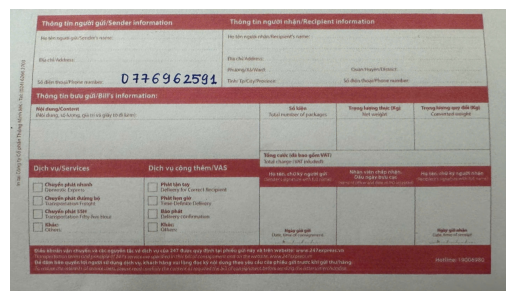

In [24]:
#@ Dự đoán bằng SVM
import matplotlib.pyplot as plt
img_test = 'demo2.jpg'
hog_predict,_ = predict_phone_number(img_test, 
                                    extract_feature=extract_hog,    # đặc trưng 
                                    model=model_svm_hog,                  # mô hình
                                    k=10)                                   # số kí tự
sobel_predict,_ = predict_phone_number(img_test,
                                       extract_feature=extract_sobel_edges,
                                       model=model_svm_sobel,
                                       k = 10)
# Đọc ảnh từ file
image = cv2.imread(img_test)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

print('Hog predict:', hog_predict)
print('Sobel predict:', sobel_predict)
# Hiển thị ảnh
plt.imshow(image)
plt.axis('off')  # Tắt trục
plt.show()

In [ ]:
#@ Dự đoán bằng KNN
import matplotlib.pyplot as plt
img_test = 'demo2.jpg'
hog_predict,_ = predict_phone_number(img_test, 
                                    extract_feature=extract_hog,    # đặc trưng 
                                    model=model_knn_hog,                  # mô hình
                                    k=20)                                   # số kí tự
sobel_predict,_ = predict_phone_number(img_test,
                                       extract_feature=extract_sobel_edges,
                                       model=model_knn_sobel,
                                       k = 10)
# Đọc ảnh từ file
image = cv2.imread(img_test)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

print('Hog predict:', hog_predict)
print('Sobel predict:', sobel_predict)
# Hiển thị ảnh
plt.imshow(image)
plt.axis('off')  # Tắt trục
plt.show()